In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import os

In [3]:
from config import DATA_DIR

curreny_file = PROJECT_ROOT / DATA_DIR / "processed" / "usd_tl.csv"
raw_currency_file = PROJECT_ROOT / DATA_DIR / "raw" / "usd_tl.csv"
figures_dir = PROJECT_ROOT / "figures" / "currency"
os.makedirs(figures_dir, exist_ok=True)

**RAW CURRENCY WITH WEEKEND HOLIDAY GAPS**

In [4]:
df = pd.read_csv(raw_currency_file, parse_dates=["Date"])
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.rename(columns={"USD_TL_Exchange_Rate": "USD_TL"}, inplace=True)


In [5]:
df.describe()

,Date,USD_TL
count,9862,6.789000e+03
mean,2012-07-01 12:00:00,2.490225e+05
min,1999-01-01 00:00:00,1.150400e+00
25%,2005-10-01 06:00:00,1.762000e+00
50%,2012-07-01 12:00:00,4.656800e+00
75%,2019-04-01 18:00:00,3.793290e+01
max,2025-12-31 00:00:00,1.754813e+06
std,NaN,5.138015e+05


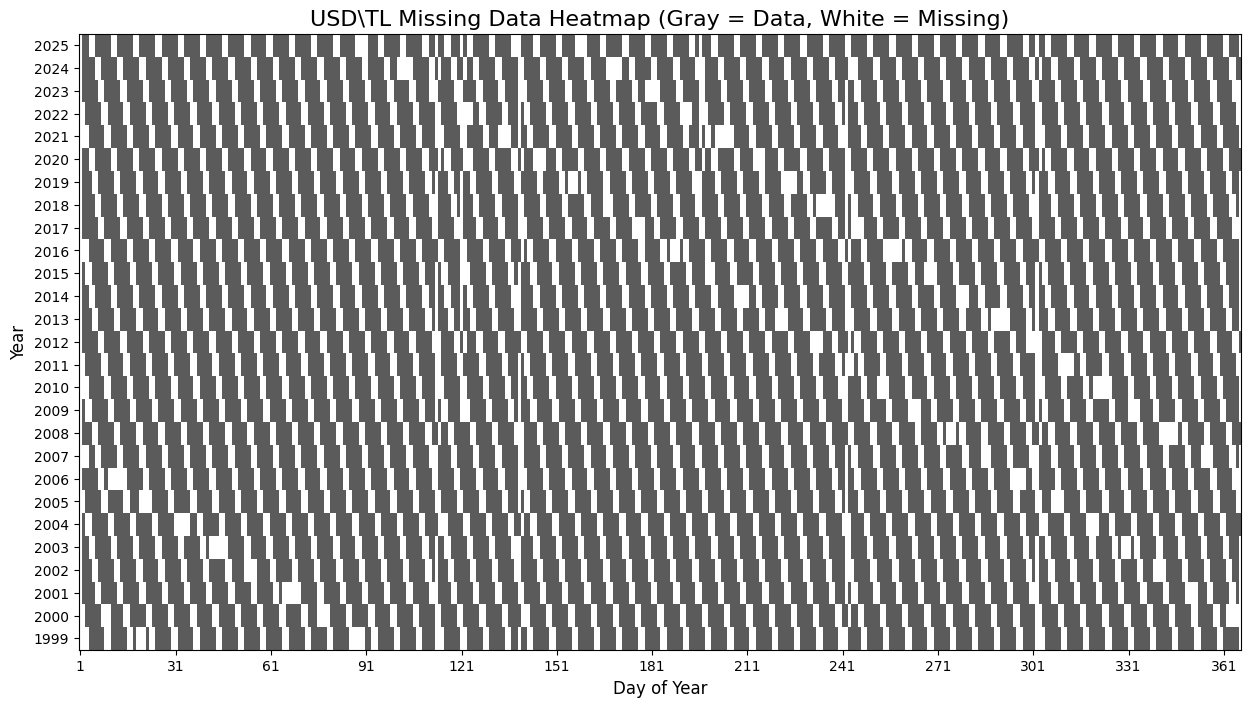

In [ ]:
df['is_missing'] = df['USD_TL'].isna().astype(int)

df['day_of_year'] = df['Date'].dt.dayofyear
df['year'] = df['Date'].dt.year

heatmap_data = df.pivot_table(
    values='is_missing',
    index='year',
    columns='day_of_year',
    aggfunc='first'
)

heatmap_data = heatmap_data.fillna(1).astype(int)

cmap = ListedColormap(['#5b5b5b', 'white'])

plt.figure(figsize=(15, 8))
plt.imshow(
    heatmap_data,
    cmap=cmap,
    aspect='auto',
    interpolation='none',
    origin='lower'
)

plt.title('USD\TL Missing Data Heatmap (Gray = Data, White = Missing)', fontsize=16)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.xticks(
    ticks=np.arange(0, 365, 30),
    labels=[str(i+1) for i in range(0, 365, 30)]
)

plt.yticks(
    ticks=np.arange(len(heatmap_data.index)),
    labels=heatmap_data.index
)

plt.savefig(figures_dir / "usd-tl-missing-heatmap.png")
plt.show()


C:\Users\Yusuf Efdal Yılmaz\AppData\Local\Temp\ipykernel_4868\4154457813.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: len(x))


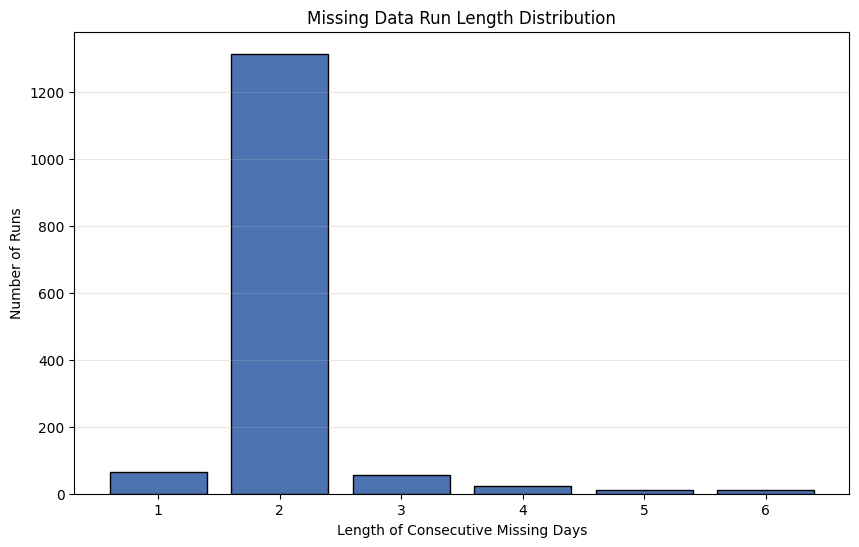

In [9]:
df = pd.read_csv(raw_currency_file, parse_dates=["Date"])

df = df.sort_values("Date")

df.rename(columns={"USD_TL_Exchange_Rate": "USD_TL"}, inplace=True)

df["is_miss"] = df["USD_TL"].isna()

# group consecutive missing status
df['missing_group'] = (df['is_miss'] != df['is_miss'].shift()).cumsum()

missing_segments = (
    df[df["is_miss"]]
      .groupby('missing_group')
      .apply(lambda x: len(x))
      .reset_index(name='run_length')
)

counts = missing_segments["run_length"].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values, edgecolor="k", color="#4C72B0")
plt.title("Missing Data Run Length Distribution")
plt.xlabel("Length of Consecutive Missing Days")
plt.ylabel("Number of Runs")
plt.xticks(counts.index)
plt.grid(axis="y", alpha=0.3)

plt.savefig(figures_dir / "usd-tl-missing-hist.png")
plt.show()

**INTERPOLATED AND FILLED(BFILL, FFILL) CURRENCY**

In [11]:
currency = pd.read_csv(curreny_file, parse_dates=['Date'])
currency = currency.set_index('Date').asfreq('D')

currency['Year'] = currency.index.year
currency['DayOfYear'] = currency.index.dayofyear

currency['USD_TL_norm'] = currency.groupby('Year')['USD_TL'].transform(lambda x: x / x.iloc[0])

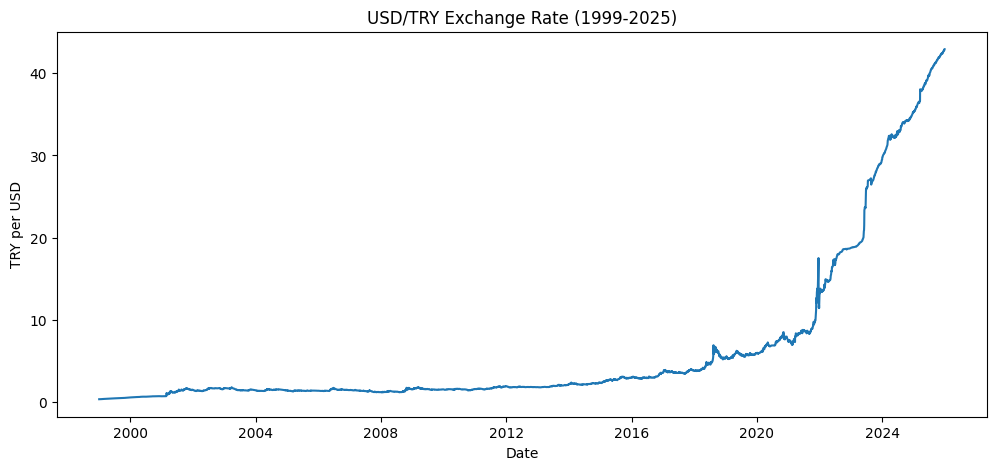

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(data=currency['USD_TL'])
plt.title("USD/TRY Exchange Rate (1999-2025)")
plt.ylabel("TRY per USD")

plt.savefig(figures_dir / "usd-tl-rates.png")
plt.show()


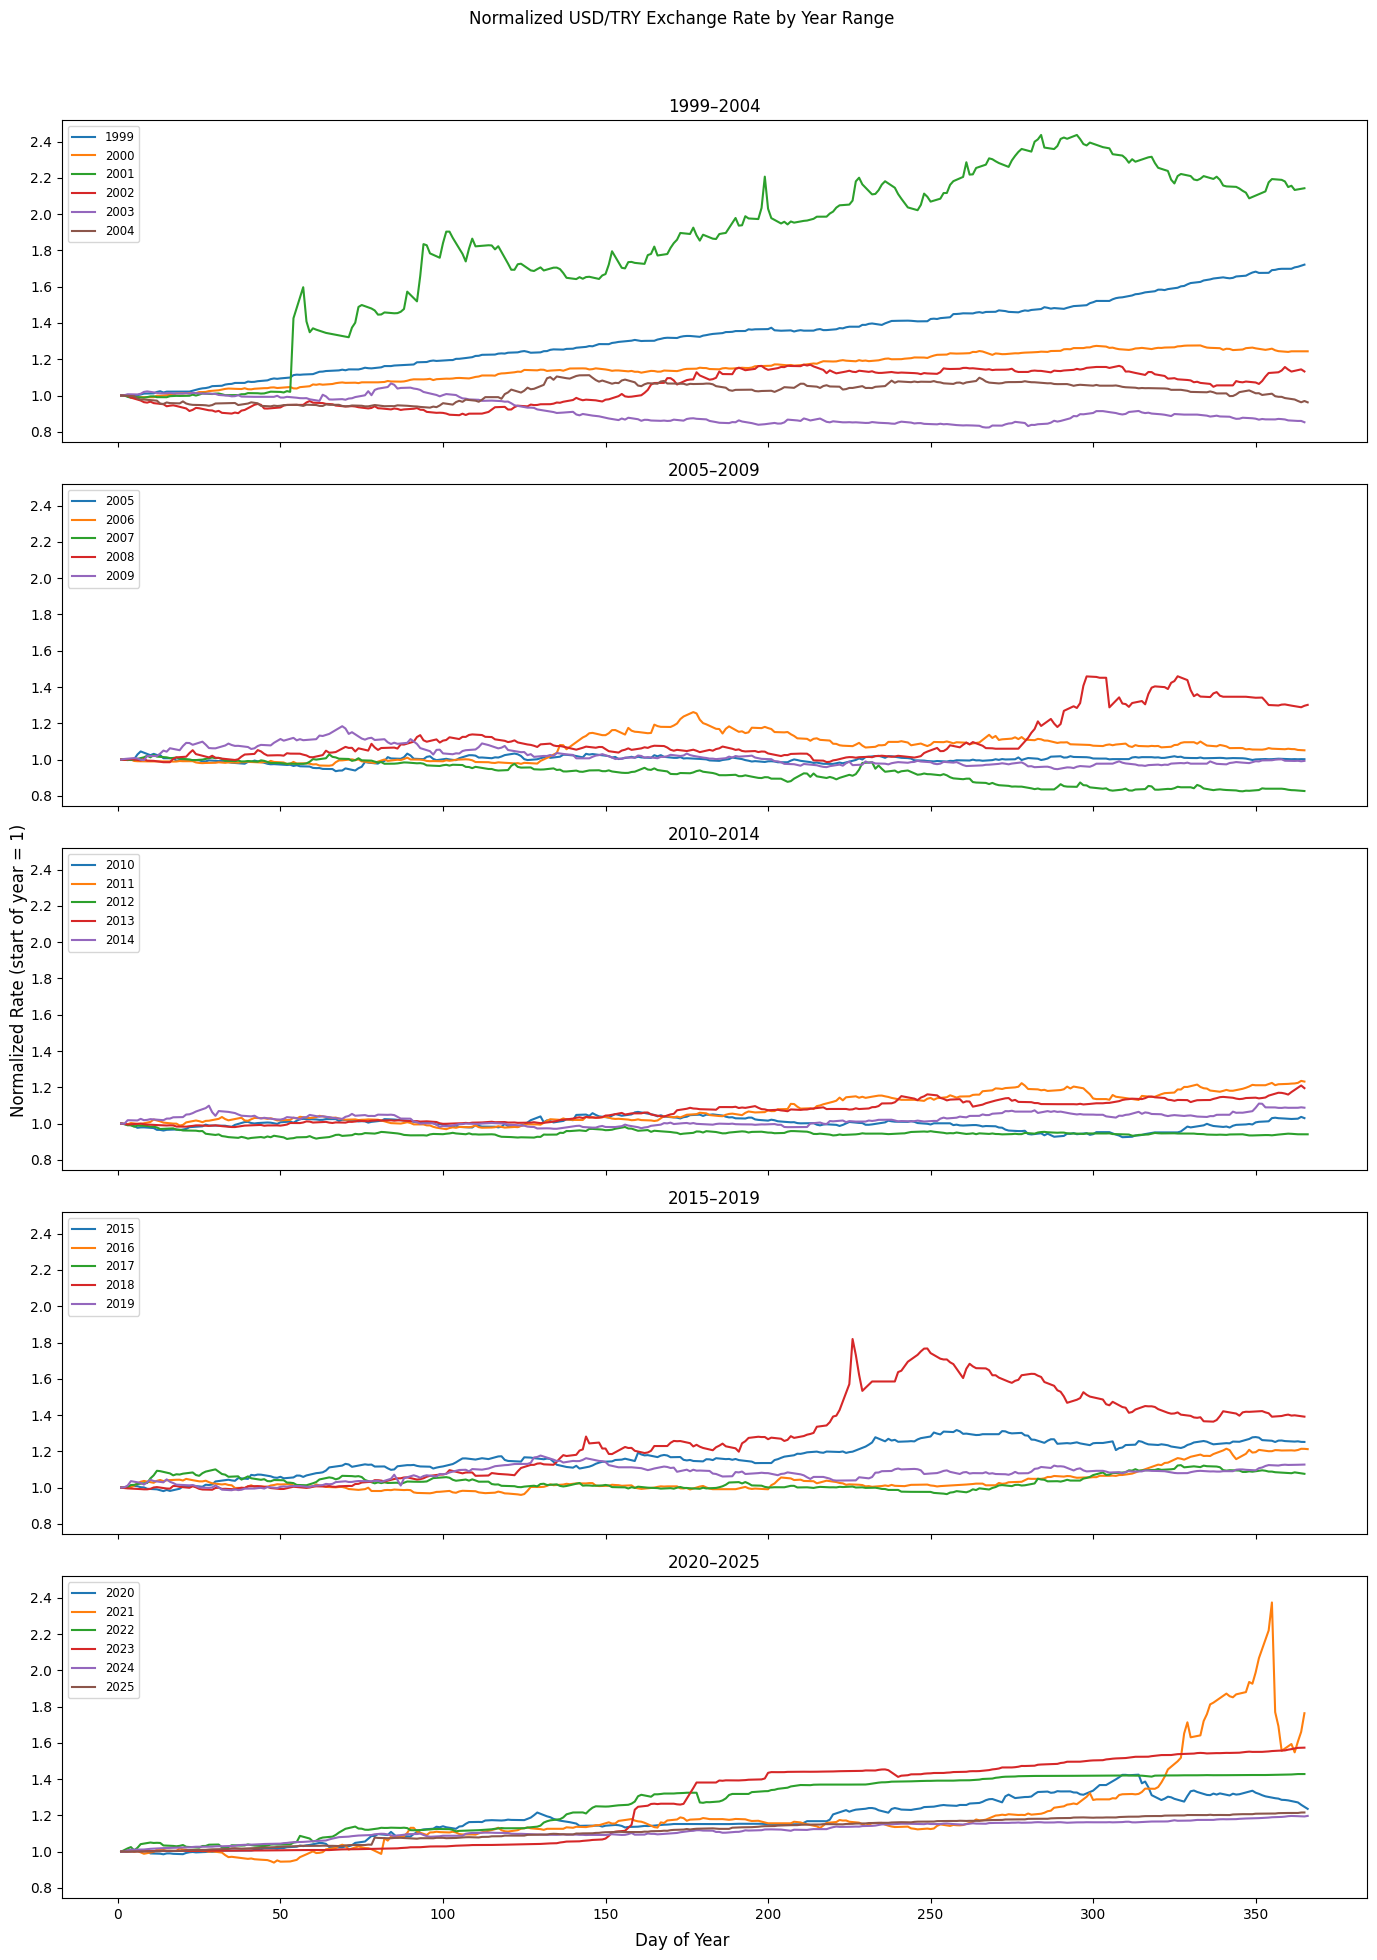

In [13]:
year_ranges = [
    range(1999, 2005),
    range(2005, 2010),
    range(2010, 2015),
    range(2015, 2020),
    range(2020, 2026),
]

fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True, sharey=True)

for ax, yr_range in zip(axes, year_ranges):
    for year in yr_range:
        group = currency[currency['Year'] == year]
        if not group.empty:
            ax.plot(group['DayOfYear'], group['USD_TL_norm'], label=str(year))
    ax.set_title(f"{min(yr_range)}–{max(yr_range)}")
    ax.legend(loc='upper left', fontsize='small')

fig.suptitle("Normalized USD/TRY Exchange Rate by Year Range")
fig.supxlabel("Day of Year")
fig.supylabel("Normalized Rate (start of year = 1)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(figures_dir / "usd-tl-rates-byyears.png")
plt.show()


In [14]:
currency.groupby(currency.index.year)['USD_TL'].describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
1999,365.0,0.419433,0.059962,0.315220,0.372963,0.422262,0.460737,0.542703
2000,366.0,0.626515,0.045319,0.537722,0.590918,0.623952,0.671036,0.692536
2001,365.0,1.229382,0.292666,0.666940,1.078163,1.280046,1.468466,1.644837
2002,365.0,1.511917,0.137050,1.292748,1.369685,1.554268,1.642267,1.696553
2003,365.0,1.502997,0.109447,1.354525,1.409215,1.464344,1.620978,1.754813
2004,366.0,1.429436,0.071842,1.307617,1.349359,1.446983,1.492281,1.558189
2005,365.0,1.347194,0.024085,1.260100,1.337100,1.350100,1.361900,1.406800
2006,365.0,1.436473,0.092321,1.302700,1.337700,1.449467,1.493900,1.701600
2007,365.0,1.306700,0.084321,1.168200,1.216000,1.319600,1.383433,1.456800


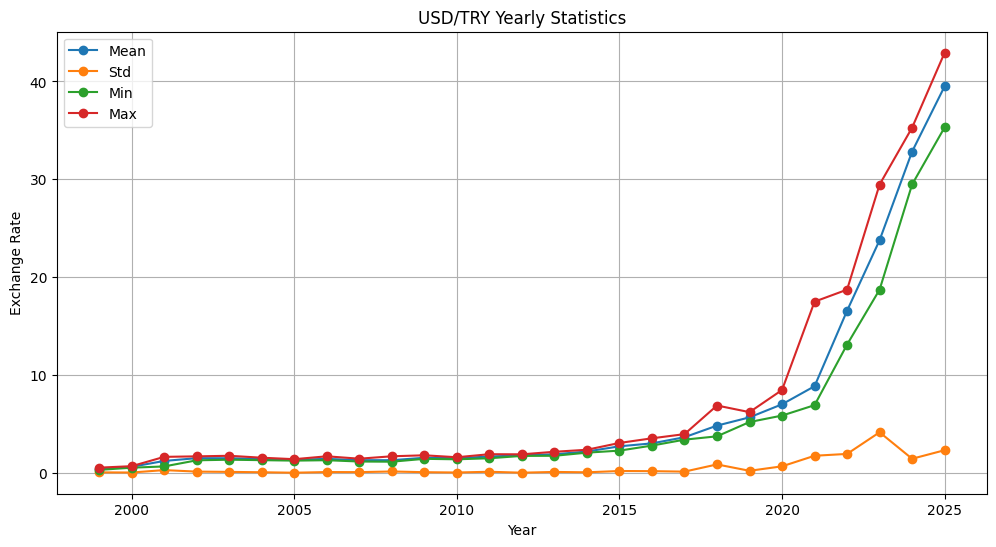

In [15]:
yearly_stats = currency['USD_TL'].groupby(currency.index.year).agg(
    mean='mean',
    std='std',
    min='min',
    max='max'
)

plt.figure(figsize=(12, 6))

plt.plot(yearly_stats.index, yearly_stats['mean'], label='Mean', marker='o')
plt.plot(yearly_stats.index, yearly_stats['std'], label='Std', marker='o')
plt.plot(yearly_stats.index, yearly_stats['min'], label='Min', marker='o')
plt.plot(yearly_stats.index, yearly_stats['max'], label='Max', marker='o')

plt.title("USD/TRY Yearly Statistics")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)

plt.savefig(figures_dir / "usd-tl-year-stats.png")
plt.show()